# Epipolar Geometry and Fundamental Matrix

In [ ]:
## Import necessary libraries here (You can add libraries you want to use here)
import os
import random
import cv2
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

## Overview

In this problem, we will implement an algorithm for automatically estimating homography with RANSAC. In the file matches.mat, we can find the detected Harris corners row-column positions in variables r1 c1 for the first image; variables r2 c2 for the second image; and the corresponding matched pairs in the variable matches.

<!-- <img src="https://drive.google.com/uc?id=1Tr723u5OXmwkd4RDmu9z886ITJU9j1cL&export=download" width="800"/> -->

<img src="https://drive.google.com/uc?id=17mwO8QH24vw1Kv1aBONgFXKi53HqUMEd&export=download" width="800"/>


The outline of the normalized 8-point algorithm:

<img src="https://drive.google.com/uc?id=1nVnvBpKeLmiowT9Q4_QauogXpcdXBmHm&export=download" width="700"/>



## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1cn3_SscjlLrf4BzUWe8MV-XqMqBY4Nj_
!unzip "/content/Part1_data.zip" -d "/content/"
# Load Matches
data = loadmat('/content/Part1_data/matches.mat')
r1 = data['r1']
r2 = data['r2']
c1 = data['c1']
c2 = data['c2']
matches = data['matches']

Downloading...
From: https://drive.google.com/uc?id=1cn3_SscjlLrf4BzUWe8MV-XqMqBY4Nj_
To: /content/Part1_data.zip
100% 157k/157k [00:00<00:00, 62.5MB/s]
Archive:  /content/Part1_data.zip
   creating: /content/Part1_data/
  inflating: /content/Part1_data/chapel00.png  
  inflating: /content/Part1_data/chapel01.png  
  inflating: /content/Part1_data/matches.mat  


In [ ]:
# Load Keypoints
x1 = c1[matches[:,0]-1]
y1 = r1[matches[:,0]-1]
x2 = c2[matches[:,1]-1]
y2 = r2[matches[:,1]-1]

## Helper Functions

In [ ]:
from scipy.ndimage import gaussian_filter as gf
from google.colab.patches import cv2_imshow

def show_image(img, scale=1.0):
    plt.figure(figsize=scale* plt.figaspect(1))
    plt.imshow(img, interpolation='nearest')
    plt.gray() 
    plt.axis('off')
    plt.show()

### Code

In [ ]:
def ransacF(x1, y1, x2, y2, thresh = 0.04):
  # Find normalization matrix
  # Transform point set 1 and 2
  # RANSAC based 8-point algorithm
  # YOUR CODE HERE: 

  pt1 = normalize(x1, y1)
  pt2 = normalize(x2, y2)

  inliers = []
  F_bank = []
  indices = []

  for i in range(5000):
    rand = np.random.choice(x1.shape[0], 8, replace=False)
    x1R = pt1[:,0][rand]
    y1R = pt1[:,1][rand]
    x2R = pt2[:,0][rand]
    y2R = pt2[:,1][rand]

    F = computeF(x1R, y1R, x2R, y2R)

    inlier, index = getInliers(pt1, pt2, F, thresh)

    inliers.append(inlier)
    indices.append(index)
    F_bank.append(F)

  best = np.argmax(np.array(inliers))
  F_best = F_bank[best]
  indices_best = np.array(indices[best])

  F_best = denormalize(x1, y1, x2, y2, F_best)

  return F_best, indices_best

def getInliers(pt1, pt2, F, thresh):
  # Function: implement the criteria checking inliers. 
  # YOUR CODE HERE:

  inliers = 0
  indices = []

  for i in range(pt1.shape[0]):
    p1 = pt1[i,:].reshape((1,3))
    p2 = pt2[i,:].reshape((1,3))

    n1 = F @ p2.T
    d1 = np.abs(p1 @ n1)/np.sqrt(n1[0]**2 + n1[1]**2)

    n2 = F.T @ p1.T
    d2 = np.abs(p2 @ n2)/np.sqrt(n2[0]**2 + n2[1]**2)

    score = d1 + d2
    # print(score)

    if score[0,0] < thresh:
      inliers = inliers + 1
      indices.append(i)
    
  # print(inliers)

  return inliers, indices


def normalize(x, y, matrix = False):
  # Function: find the transformation to make it zero mean and the variance as sqrt(2)
  # YOUR CODE HERE:
  og_coord = np.ones((x.shape[0],3))
  og_coord[:,0] = x[:,0]
  og_coord[:,1] = y[:,0]

  mean = (np.mean(x),np.mean(y))
  translate = np.array([[1,0,-mean[0]],
                        [0,1,-mean[1]],
                        [0,0,1]])
  
  coord = np.transpose(np.dot(translate, np.transpose(og_coord)))

  k_x = np.sqrt((x.shape[0])/(np.sum(coord[:,0]**2)))
  k_y = np.sqrt((y.shape[0])/(np.sum(coord[:,1]**2)))

  scaling = np.array([[k_x,0,0],
                      [0,k_y,0],
                      [0,0,1]])
  
  coord = np.transpose(np.dot(scaling, np.transpose(coord)))

  # x_new = coord[:,0]
  # y_new = coord[:,1]

  if matrix:
    T = np.dot(scaling, translate)
    return T
  
  else:
    return coord

  
def computeF(x1, y1, x2, y2):
  #  Function: compute fundamental matrix from corresponding points
  # YOUR CODE HERE: 
  A = np.zeros((x1.shape[0],9))
  for i in range(x1.shape[0]):
    x = x1[i]
    x_ = x2[i]
    y = y1[i]
    y_ = y2[i]
    A[i,:] = np.array([x*x_ , x*y_ , x , y*x_ , y*y_ , y , x_ , y_ , 1])

  _ , _ , V = np.linalg.svd(A)
  # print(V.shape)
  f = V.T[:,8]
  F = np.reshape(f, (3,3))

  U, S, V = np.linalg.svd(F)
  S = np.array([[S[0],0,0],[0,S[1],0],[0,0,0]])

  F = U @ S @ V

  return F

def denormalize(x1, y1, x2, y2, F):
  # Function: to reverse the normalization process and get the resultant fundamental matrix
  T = normalize(x1, y1, matrix = True)
  T_ = normalize(x2, y2, matrix = True)
  # F_denormalized = np.dot(np.transpose(T_) , np.dot(F, T))
  F_denormalized = T.T @ F @ T_

  return F_denormalized

def error(x1, y1, x2, y2, F):
  a1 = np.hstack((x1, y1, np.ones((x1.shape[0], 1))))
  a2 = np.hstack((x2, y2, np.ones((x2.shape[0], 1))))

  error = 0

  for i in range(a1.shape[0]):
    p1 = a1[i,:].reshape((1,3))
    p2 = a2[i,:].reshape((1,3))

    n1 = F @ p2.T
    d1 = np.abs(p1 @ n1)/np.sqrt(n1[0]**2 + n1[1]**2)

    n2 = F.T @ p1.T
    d2 = np.abs(p2 @ n2)/np.sqrt(n2[0]**2 + n2[1]**2)

    error = error + (d1 + d2)

  error = error/a1.shape[0]
  return error[0,0]

#Visualization

Helper functions

In [ ]:
img1 = cv2.imread("/content/Part1_data/chapel00.png", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("/content/Part1_data/chapel01.png", cv2.IMREAD_GRAYSCALE)

In [ ]:
def getBestMatches(indices,x1,y1,x2,y2):
  # Function to filter out the best matches
  a1 = np.hstack((x1, y1, np.ones((x1.shape[0], 1))))
  a2 = np.hstack((x2, y2, np.ones((x2.shape[0], 1))))

  a1 = a1[indices]
  a2 = a2[indices]

  return a1, a2

In [ ]:
def drawLines(x1, y1, x2, y2, indices, img1, img2, F):
  # Function to visualize the epipolar lines

  rand = np.random.choice(indices.shape[0], 8, replace=False)
  
  indices = indices[rand]

  coord1, coord2 = getBestMatches(indices, x1, y1, x2, y2)

  ep_lines1 = F @ coord2.T
  ep_lines2 = F.T @ coord1.T

  img = np.zeros((img1.shape[0], img1.shape[1]*2))
  img[:,0:img1.shape[1]] = img1
  img[:,img1.shape[1]:img1.shape[1]*2] = img2

  plt.rcParams["figure.figsize"] = [30, 20]
  fig, ax = plt.subplots()
  im = ax.imshow(img, extent=[0, img.shape[1], 0, img.shape[0]], cmap='gray')

  for i in range(coord1.shape[0]):
    x1 = np.linspace(0,img1.shape[1],5)
    y1 = (-ep_lines1[0,i]*x1 - ep_lines1[2,i])/(ep_lines1[1,i])
    y1 = img1.shape[0] - y1
    plt.plot(x1, y1, '-g')
    plt.scatter(coord1[i,0],img1.shape[0]-coord1[i,1],color='r')

    x2 = np.linspace(0,img1.shape[1],5)
    y2 = (-ep_lines2[0,i]*x1 - ep_lines2[2,i])/(ep_lines2[1,i])
    y2 = img1.shape[0] - y2
    plt.plot(x2 + img1.shape[1], y2, '-g')
    plt.scatter(coord2[i,0] + img1.shape[1] ,img1.shape[0]-coord2[i,1],color='r')

  plt.xlim([0, img1.shape[1]*2])
  plt.ylim([0, img1.shape[0]])
  plt.show()

### Write-up
*   Describing the test that was used for deciding inlier vs. outlier.

Let the matched feature points in image2 be X' and in image1 be X. For every point in X we find the corresponding epipolar line in image2, described by (a2,b2,c2) by F.T @ X. Then we find the distance (d2) between the corresponding point in X' to this epipolar line. And similarly, we find the epipolar line for each point in X' in image1 by F @ X', and find the distance (d1) of the corresponding point in x to these epipolar line. 

d2 = (a2*x' + b2*y' + c2)/(np.sqrt(a2^2 + b2^2)

d1 = (a1*x + b1*y + c1)/(np.sqrt(a1^2 + b1^2) 

error = d1 + d2

For each pair of matching points we do this process and the error metric for how bad a Fundamental matrix hypothesis is for that pair of matching points is given by the sum of these two distances (d1 + d2). Then we set a threshold, and if the sum of these distances is lesser than the threshold, the point is considered to be an inlier and if it is not, it is an outlier for that specific hypothesis.

if error < threshold -> inlier

if error >= threshold -> outlier



*   Display the estimated fundamental matrix F after normalizing to unit length

In [ ]:
F, indices = ransacF(x1, y1, x2, y2)

print("The estimated fundamental matrix F is as follows:\n")
F

The estimated fundamental matrix F is as follows:



array([[ 2.13024940e-08,  5.45319545e-06, -1.24588025e-03],
       [-4.81894310e-06, -3.49705815e-07, -1.07363789e-02],
       [ 1.08459431e-03,  1.06550304e-02, -9.26857871e-02]])

*   Randomly select 7 sets of matching points. Plot the corresponding epipolar lines and the points on each image. Show the two images (with plotted points and lines) next to each other.

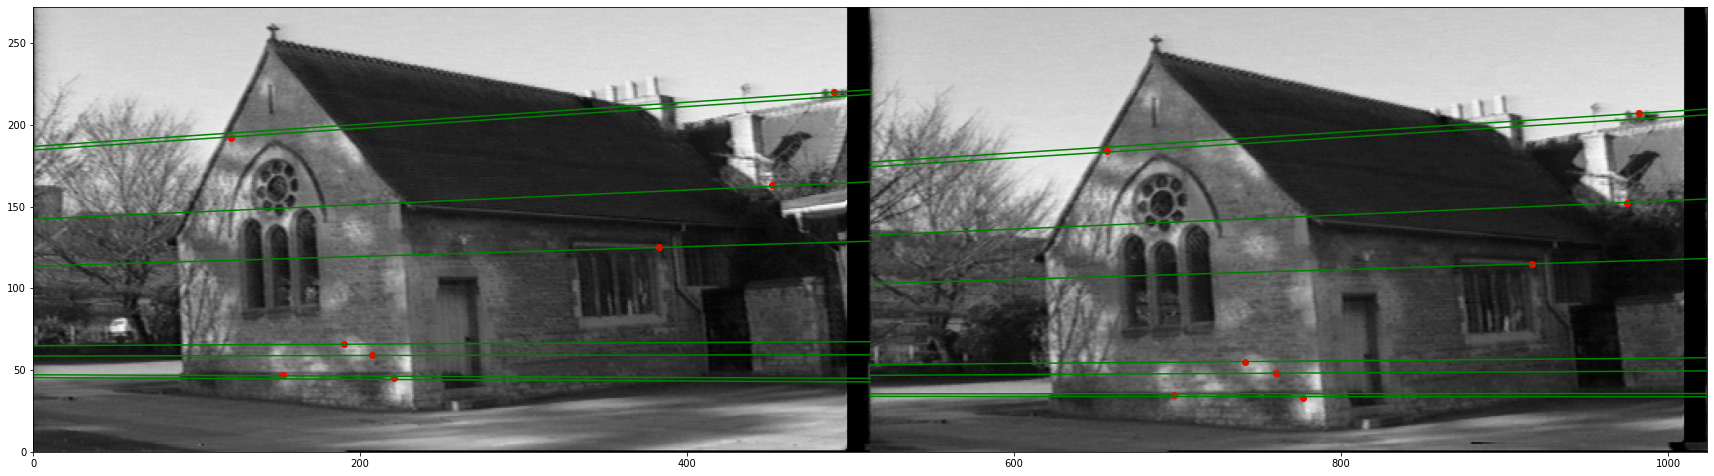

In [ ]:
drawLines(x1, y1, x2, y2, indices, img1, img2, F)